<a href="https://colab.research.google.com/github/DungNguyenCoding/FederatedLearning/blob/main/Projects/customize_federated_learning_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/federated/tutorials/building_your_own_federated_learning_algorithm"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/federated/blob/v0.88.0/docs/tutorials/building_your_own_federated_learning_algorithm.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/federated/blob/v0.88.0/docs/tutorials/building_your_own_federated_learning_algorithm.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/federated/docs/tutorials/building_your_own_federated_learning_algorithm.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Before you start

Before you start, please run the following to make sure that your environment is
correctly setup. If you don't see a greeting, please refer to the
[Installation](../install.md) guide for instructions.

In [3]:
!pip uninstall -y tensorflow-federated

Found existing installation: tensorflow_federated 0.84.0
Uninstalling tensorflow_federated-0.84.0:
  Successfully uninstalled tensorflow_federated-0.84.0


In [5]:
!pip install --quiet --upgrade tensorflow-federated

In [6]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

# Customize Federated Learning Algorithm

In the image classification notebook, I learned how to set up model and data pipelines for Federated Learning (FL), and performed federated training via the `tff.learning` API layer of TFF.

This is only the tip of the iceberg when it comes to FL research. This notebook discusses how to implement federated learning algorithms *without* deferring to the `tff.learning` API.

**Goals:**


*   Understand the general structure of federated learning algorithms.
*   Explore the *Federated Core* of TFF.
*   Use the Federated Core to implement Federated Averaging directly.


# Introduction to the Federated Core

The Federated Core (FC) is a set of lower-level interfaces that serve as the foundation for the `tff.learning` API. However, these interfaces are not limited to learning. In fact, they can be used for analytics and many other computations over distributed data.

At a high-level, the federated core is a development environment that enables compactly expressed program logic to combine TensorFlow code with distributed communication operators (such as distributed sums and broadcasts). The goal is to give researchers and practitioners explicit control over the distributed communication in their systems, without requiring system implementation details (such as specifying point-to-point network message exchanges).

One key point is that TFF is designed for privacy-preservation. Therefore, it allows explicit control over where data resides, to prevent unwanted accumulation of data at the centralized server location.

## Federated data

A key concept in TFF is "federated data", which refers to a collection of data items hosted across a group of devices in a distributed system (eg. client datasets, or the server model weights). The entire collection of values across all devices is represented as a single *federated value*.

For example, suppose there are client devices that each have a float representing the temperature of a sensor. These floats can be represented as a *federated float* by

In [74]:
federated_float_on_clients = tff.FederatedType(np.float32, tff.CLIENTS)

Federated types are specified by a type `T` of its member constituents (eg. `np.float32`) and a group `G` of devices. Typically, `G` is either `tff.CLIENTS` or `tff.SERVER`. Such a federated type is represented as `{T}@G`, as shown below.

In [75]:
str(federated_float_on_clients)

'{float32}@CLIENTS'

Why does TFF care so much about placements? A key goal of TFF is to enable writing code that could be deployed on a real distributed system. This means that it is vital to reason about which subsets of devices execute which code, and where different pieces of data reside.

TFF focuses on three things: *data*, where the data is *placed*, and how the data is being *transformed*. The first two are encapsulated in federated types, while the last is encapsulated in *federated computations*.

## Federated computations

TFF is a strongly-typed functional programming environment whose basic units are *federated computations*. These are pieces of logic that accept federated values as input, and return federated values as output.

For example, suppose you wanted to average the temperatures on our client sensors. You could define the following (using our federated float):

In [78]:
@tff.federated_computation(tff.FederatedType(np.float32, tff.CLIENTS))
def get_average_temperature(client_temperatures):
  return tff.federated_mean(client_temperatures)

You can think of TFF computations as functions with well-defined type signatures. These type signatures can be directly queried.

In [79]:
str(get_average_temperature.type_signature)

'({float32}@CLIENTS -> float32@SERVER)'

This `tff.federated_computation` accepts arguments of federated type `{float32}@CLIENTS`, and returns values of federated type `{float32}@SERVER`. Federated computations may also go from server to client, from client to client, or from server to server. Federated computations can also be composed like normal functions, as long as their type signatures match up.

In summary:

*   TFF operates on federated values.
*   Each federated value has a *federated type*, with a *type* (eg. `np.float32`) and a *placement* (eg. `tff.CLIENTS`).
*   Federated values can be transformed using *federated computations*, which must be decorated with `tff.federated_computation` and a federated type signature.
*   TensorFlow code must be contained in blocks with `tff.tensorflow.computation` decorators.
*   These blocks can then be incorporated into federated computations.


## Preparing the input data
First load and preprocess the EMNIST dataset included in TFF. For more details, see the [image classification](federated_learning_for_image_classification.ipynb) tutorial.

In [7]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

In order to feed the dataset into our model, the data is flattened, and each example is converted into a tuple of the form `(flattened_image_vector, label)`.

In [8]:
NUM_CLIENTS = 10
BATCH_SIZE = 20

def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch of EMNIST data and return a (features, label) tuple."""
    return (tf.reshape(element['pixels'], [-1, 784]),
            tf.reshape(element['label'], [-1, 1]))

  return dataset.batch(BATCH_SIZE).map(batch_format_fn)

Now, select a small number of clients, and apply the preprocessing above to their datasets.

In [9]:
client_ids = sorted(emnist_train.client_ids)[:NUM_CLIENTS]
federated_train_data = [preprocess(emnist_train.create_tf_dataset_for_client(x))
  for x in client_ids
]

## Preparing the model

This uses the same model as in the image classification notebook. This model (implemented via `tf.keras`) has a single hidden layer, followed by a softmax layer.

In [10]:
def create_keras_model():
  initializer = tf.keras.initializers.GlorotNormal(seed=0)
  return tf.keras.models.Sequential([
      tf.keras.layers.Input(shape=(784,)),
      tf.keras.layers.Dense(10, kernel_initializer=initializer),
      tf.keras.layers.Softmax(),
  ])

In order to use this model in TFF, wrap the Keras model as a [`tff.learning.models.FunctionalModel`](https://www.tensorflow.org/federated/api_docs/python/tff/learning/models/FunctionalModel). This allows one to perform the model's [forward pass](https://www.tensorflow.org/federated/api_docs/python/tff/learning/models/FunctionalModel#predict_on_batch) within TFF, and [extract model outputs](https://www.tensorflow.org/federated/api_docs/python/tff/learning/models/FunctionalModel#finalize_metrics). For more details, also see the image classification notebook.

In [11]:
keras_model = create_keras_model()
tff_model = tff.learning.models.functional_model_from_keras(
    keras_model,
    loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(),
    input_spec=federated_train_data[0].element_spec,
    metrics_constructor=collections.OrderedDict(
        accuracy=tf.keras.metrics.SparseCategoricalAccuracy
    ),
)

While the above used `tf.keras` to create a `tff.learning.models.FunctionalModel`, TFF supports much more general models. These models have the following relevant attributes capturing the model weights:

*   `trainable_variables`: An iterable of the tensors corresponding to trainable layers.
*   `non_trainable_variables`: An iterable of the tensors corresponding to non-trainable layers.

In this tutorial, only the `trainable_variables` will be used (as the model only has those!).

# Building your own Federated Learning algorithm

While the `tff.learning` API allows one to create many variants of Federated Averaging, there are other federated algorithms that do not fit neatly into this framework. For example, you may want to add regularization, clipping, or more complicated algorithms such as [federated GAN training](https://github.com/tensorflow/federated/tree/main/tensorflow_federated/python/research/gans). You may also be instead be interested in [federated analytics](https://ai.googleblog.com/2020/05/federated-analytics-collaborative-data.html).

For these more advanced algorithms, you'll have to write our own custom algorithm using TFF. In many cases, federated algorithms have 4 main components:

1. A server-to-client broadcast step.
2. A local client update step.
3. A client-to-server upload step.
4. A server update step.

In TFF, a federated algorithm is typically represented as a [`tff.templates.IterativeProcess`](https://www.tensorflow.org/federated/api_docs/python/tff/templates/IterativeProcess) (which will be referred to as just an `IterativeProcess` throughout). This is a class that contains `initialize` and `next` functions. Here, `initialize` is used to initialize the server, and `next` will perform one communication round of the federated algorithm. Let's write a skeleton of what our iterative process for FedAvg should look like.

First, let's write a sketch of the `next_fn`.

In [80]:
# def next_fn(server_weights, federated_dataset):

#   1/ Broadcast the server weights to the clients.
#   server_weights_at_client = broadcast(server_weights)

#   2/ Each client computes their updated weights.
#   client_weights = client_update(federated_dataset, server_weights_at_client)

#   3/ The server averages these updates.
#   mean_client_weights = mean(client_weights)

#   4/ The server updates its model.
#   server_weights = server_update(mean_client_weights)

#   return server_weights

Let's focus on implementing these four components separately. First, let's focus on the parts that can be implemented in pure TensorFlow, namely the client and server update steps.

## TensorFlow Blocks

### Client update

The `tff.learning.models.FunctionalModel` can be used to do client training in essentially the same way you would train a TensorFlow model. In particular, one can use `tf.GradientTape` to compute the gradient on batches of data, then apply these gradient using a `client_optimizer`. This will only involve the trainable weights.


**Summary**\
This function:
- Mimics what each client does during a federated training round.
- Applies gradient-based updates locally, without communicating with the server.
- Is essential for customizing federated training beyond the default TFF algorithms.

In [81]:
@tf.function
def client_update(model, dataset, initial_weights, client_optimizer):
  """Performs training (using the server model weights) on the client's dataset."""
  # Initialize the client model with the current server weights and the optimizer state.
  ## Copies the trainable part of the global model weights sent by the server.
  client_weights = initial_weights.trainable
  ## Initializes the optimizer state (e.g., momentum variables).
  optimizer_state = client_optimizer.initialize(
      tf.nest.map_structure(tf.TensorSpec.from_tensor, client_weights)
  )

  # Use the client_optimizer to update the local model
  for batch in dataset:
    x, y = batch
    with tf.GradientTape() as tape:
      tape.watch(client_weights)
      # Compute a forward pass on the batch of data
      ## Passes inputs x through the model to get predictions
      outputs = model.predict_on_batch(
          model_weights=(client_weights, ()), x=x, training=True
      )
      # Computes the loss using SparseCategoricalCrossentropy
      loss = model.loss(output=outputs, label=y)

    # Compute the corresponding gradient
    grads = tape.gradient(loss, client_weights)

    # Updates model weights using the gradients via the optimize
    optimizer_state, client_weights = client_optimizer.next(
        optimizer_state, weights=client_weights, gradients=grads
    )

  return tff.learning.models.ModelWeights(client_weights, non_trainable=())

### Server Update

The server update for FedAvg is simpler than the client update. This tutorial will implement "vanilla" federated averaging, in which the server model weights are replaced by the average of the client model weights. Again, this only uses the trainable weights.

In [52]:
@tf.function
def server_update(model, mean_client_weights):
  """Updates the server model weights as the average of the client model weights."""
  del model  # Unused, just take the mean_client_weights.
  return mean_client_weights

The snippet could be simplified by simply returning the `mean_client_weights`. However, more advanced implementations of Federated Averaging use `mean_client_weights` with more sophisticated techniques, such as momentum or adaptivity.

So far, this has only involved TensorFlow code. This is by design, as TFF allows you to use much of the TensorFlow code you're already familiar with. Next you will have to specify the **orchestration logic**, that is, the logic that dictates what the server broadcasts to the client, and what the client uploads to the server, which will require the *Federated Core* of TFF.

In order to make our algorithm a federated computation, you will need both the `next_fn` and `initialize_fn` to each be a `tff.federated_computation`.

## TensorFlow Federated blocks

### Creating the initialization computation

The initialize function will be quite simple: You will create a model using `model_fn`. However, remember that you must separate out our TensorFlow code using `tff.tensorflow.computation`.

In [82]:
@tff.tensorflow.computation
def server_init():
  # Returns the initial model weights of the Keras model (trainable and non-trainable).
  return tff.learning.models.ModelWeights(*tff_model.initial_weights)

You can then pass this directly into a federated computation using `tff.federated_value`.

In [54]:
@tff.federated_computation
def initialize_fn():
  return tff.federated_eval(server_init, tff.SERVER)

### Creating the `next_fn`

The client and server update code can now be used to write the actual algorithm. First, you will turn the `client_update` into a `tff.tensorflow.computation` that accepts a client datasets and server weights, and outputs an updated client weights tensor.

You will need the corresponding types to properly decorate our function. Luckily, the type of the server weights can be extracted directly from our model.

In [55]:
tf_dataset_type = tff.SequenceType(
    tff.types.tensorflow_to_type(tff_model.input_spec)
)

Let's look at the dataset type signature. Remember that you took 28 by 28 images (with integer labels) and flattened them.

In [56]:
str(tf_dataset_type)

'<float32[?,784],int32[?,1]>*'

You can also extract the model weights type by using our `server_init` function above.

In [57]:
model_weights_type = server_init.type_signature.result

Examining the type signature, you'll be able to see the architecture of our model!

In [58]:
str(model_weights_type)

'<trainable=<float32[784,10],float32[10]>,non_trainable=<>>'

You can now create our `tff.tensorflow.computation` for the client update.

In [83]:
@tff.tensorflow.computation(tf_dataset_type, model_weights_type)
def client_update_fn(tf_dataset, server_weights):
  client_optimizer = tff.learning.optimizers.build_sgdm(learning_rate=0.01)
  # Uses client_update() to train locally on tf_dataset, starting from server_weights
  # Returns updated weights from the client.
  return client_update(tff_model, tf_dataset, server_weights, client_optimizer)

The `tff.tensorflow.computation` version of the server update can be defined in a similar way, using types you've already extracted.

In [84]:
@tff.tensorflow.computation(model_weights_type)
def server_update_fn(mean_client_weights):
  # Runs on the server after aggregating the client weights
  # Just returns the mean client weights as the new server model.
  return server_update(tff_model, mean_client_weights)

Last, but not least, you need to create the `tff.federated_computation` that brings this all together. This function will accept two *federated values*, one corresponding to the server weights (with placement `tff.SERVER`), and the other corresponding to the client datasets (with placement `tff.CLIENTS`).

Note that both these types were defined above! You simply need to give them the proper placement using `tff.FederatedType`.

In [61]:
federated_server_type = tff.FederatedType(model_weights_type, tff.SERVER)
federated_dataset_type = tff.FederatedType(tf_dataset_type, tff.CLIENTS)

Reminder:

1. A server-to-client broadcast step.
2. A local client update step.
3. A client-to-server upload step.
4. A server update step.

Now that you've built up the above, each part can be compactly represented as a single line of TFF code. This simplicity is why you had to take extra care to specify things such as federated types!

In [85]:
@tff.federated_computation(federated_server_type, federated_dataset_type)
# server_weights: The model on the server (@SERVER)
# federated_dataset: A list of datasets (one per client, @CLIENTS)
def next_fn(server_weights, federated_dataset):
  # Broadcast the server weights to all clients.
  server_weights_at_client = tff.federated_broadcast(server_weights)

  # Each client uses its local dataset and the received weights to train using client_update_fn
  # Returns updated weights from each client.
  client_weights = tff.federated_map(
      client_update_fn, (federated_dataset, server_weights_at_client)
  )

  # Aggregates all clients’ updated weights by averaging them.
  mean_client_weights = tff.federated_mean(client_weights)

  # Update Server Model with Averaged Weights
  server_weights = tff.federated_map(server_update_fn, mean_client_weights)

  return server_weights

You now have a `tff.federated_computation` for both the algorithm initialization, and for running one step of the algorithm. To finish our algorithm, you pass these into `tff.templates.IterativeProcess`.

In [86]:
federated_algorithm = tff.templates.IterativeProcess(
    initialize_fn=initialize_fn,
    next_fn=next_fn
)

Let's look at the *type signature* of the `initialize` and `next` functions of our iterative process.

In [88]:
str(federated_algorithm.initialize.type_signature)

'( -> <trainable=<float32[784,10],float32[10]>,non_trainable=<>>@SERVER)'

What it means:
- `( -> ...)`: This function takes no arguments.
- `<trainable=..., non_trainable=...>`: It returns a structure (a `ModelWeights` object) with:
  - `trainable`: the trainable parameters of the model.
    - A weights matrix: `float32[784,10]` → from input of size 784 (flattened image) to 10 output classes.
    - A bias vector: float32[10]
  - `non_trainable`: an empty tuple (<>) — meaning the model has no non-trainable weights.
- `@SERVER`: This output lives on the server.

In [65]:
str(federated_algorithm.next.type_signature)

'(<server_weights=<trainable=<float32[784,10],float32[10]>,non_trainable=<>>@SERVER,federated_dataset={<float32[?,784],int32[?,1]>*}@CLIENTS> -> <trainable=<float32[784,10],float32[10]>,non_trainable=<>>@SERVER)'

**Input**

The function takes a pair:

1. **`server_weights`**:
   - **Location**: `@SERVER`
   - **Type**: a `ModelWeights` structure:
     - `trainable`: two tensors:
       - `float32[784,10]` → dense layer weights (784 inputs → 10 classes).
       - `float32[10]` → biases.
     - `non_trainable`: empty.

2. **`federated_dataset`**:
   - **Location**: `@CLIENTS`
   - **Type**: per-client dataset of tuples:
     - `float32[?,784]` → batch of flattened EMNIST images.
     - `int32[?,1]` → batch of labels.
   - The `*` means it's a federated value — one dataset per client.

---

**Output**

- Returns: updated `server_weights` (i.e., new model weights after aggregation).
- **Location**: `@SERVER`



Here, one can see that `federated_algorithm.next` accepts a server model and client data, and returns an updated server model.

## Evaluating the algorithm

Let's run a few rounds, and see how the loss changes. First, you will define an evaluation function using the *centralized* approach discussed in the second tutorial.

You will first create a centralized evaluation dataset, and then apply the same preprocessing you used for the training data.

In [90]:
# Combines all client test datasets in the emnist_test federated dataset into one centralized tf.data.Dataset.
central_emnist_test = emnist_test.create_tf_dataset_from_all_clients()
central_emnist_test = preprocess(central_emnist_test)

Next, you will write a function that accepts a server state, and uses Keras to evaluate on the test dataset. If you're familiar with `tf.Keras`, this will all look familiar, though note the use of `set_weights`!

In [93]:
def evaluate(model_weights):
  keras_model = create_keras_model()
  keras_model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
  )
  model_weights.assign_weights_to(keras_model)
  results = keras_model.evaluate(central_emnist_test, return_dict=True)
  return results

Now, let's initialize our algorithm and evaluate on the test set.

In [98]:
server_state = federated_algorithm.initialize()

model_weights = tff.learning.models.ModelWeights(
    trainable=server_state.trainable,
    non_trainable=server_state.non_trainable,
)

evaluate(model_weights)


2042/2042 [==============================] - 8s 4ms/step - loss: 2.8479 - sparse_categorical_accuracy: 0.1027


{'loss': 2.847879648208618, 'sparse_categorical_accuracy': 0.10268906503915787}

Let's train for a few rounds and see if anything changes.

In [99]:
for _ in range(15):
  server_state = federated_algorithm.next(server_state, federated_train_data)
evaluate(server_state)

2042/2042 [==============================] - 10s 5ms/step - loss: 2.5867 - sparse_categorical_accuracy: 0.0980


{'loss': 2.5866878032684326, 'sparse_categorical_accuracy': 0.0979623794555664}

Evaluating at round 10...
Evaluating at round 20...
Evaluating at round 30...
Evaluating at round 40...
Evaluating at round 50...
Evaluating at round 60...
Evaluating at round 70...
Evaluating at round 80...
Evaluating at round 90...
Evaluating at round 100...


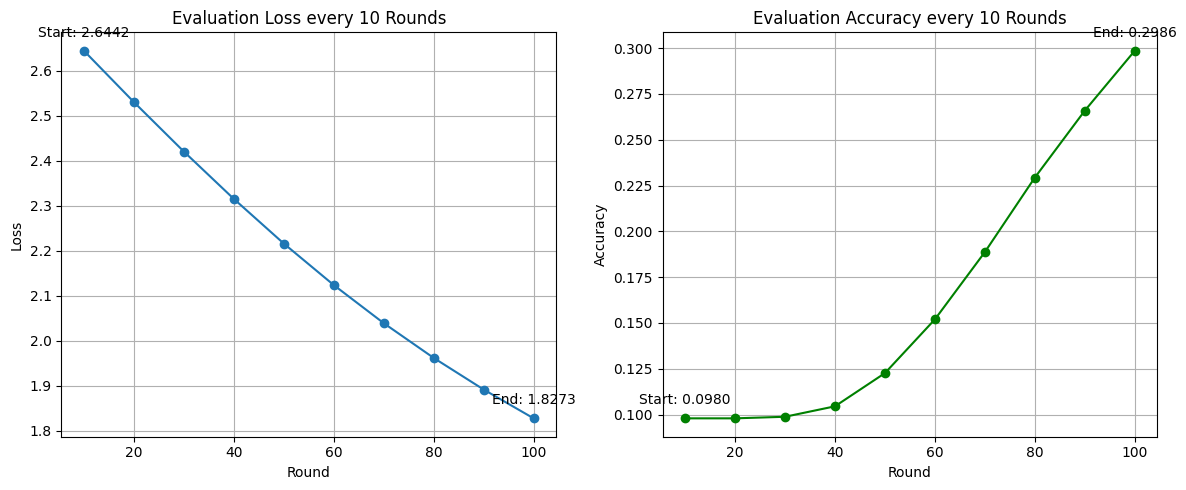

In [95]:
import matplotlib.pyplot as plt

# Prepare storage for evaluation results
rounds = []
losses = []
accuracies = []

# Number of training rounds
NUM_ROUNDS = 100

# Start with initialized server state
server_state = federated_algorithm.initialize()

# Training and evaluation loop
for round_num in range(1, NUM_ROUNDS + 1):
    # Run one round of training
    server_state = federated_algorithm.next(server_state, federated_train_data)

    # Evaluate every 10 rounds
    if round_num % 10 == 0:
        print(f"Evaluating at round {round_num}...")
        model_weights = server_state  # Contains trainable and non_trainable
        keras_model = create_keras_model()
        keras_model.compile(
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
        )
        model_weights.assign_weights_to(keras_model)

        eval_results = keras_model.evaluate(central_emnist_test, verbose=0, return_dict=True)

        rounds.append(round_num)
        losses.append(eval_results['loss'])
        accuracies.append(eval_results['sparse_categorical_accuracy'])

# Plotting evaluation metrics
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(rounds, losses, marker='o')
plt.title("Evaluation Loss every 10 Rounds")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.grid(True)
plt.annotate(f"Start: {losses[0]:.4f}", (rounds[0], losses[0]), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate(f"End: {losses[-1]:.4f}", (rounds[-1], losses[-1]), textcoords="offset points", xytext=(0,10), ha='center')

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(rounds, accuracies, marker='o', color='green')
plt.title("Evaluation Accuracy every 10 Rounds")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.grid(True)
plt.annotate(f"Start: {accuracies[0]:.4f}", (rounds[0], accuracies[0]), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate(f"End: {accuracies[-1]:.4f}", (rounds[-1], accuracies[-1]), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()
